# Anomaly Detection in Time Series with low rank signals via Robust Principal Component Analysis

For data driven companies, handling data sources with ever increasing size, quantity or velocity, human anomaly supervision isn't a viable option anymore. Many of these companies already have deployed systems to detect, track, visualize and make their ops team aware of any anomalies automatically. Here we will explore an (additional) option to automatically detect potential anomalies in time series via [Robust Principal Component Analysis (RPCA)][rpca]. We generate sample data, emulating sensors recording signals with seasonal characteristics to show how RPCA can be applied. Further we conduct the same setup for recorded real world ad exchange data (cost per impressions) from the [Numenta Anomaly Benchmark (NAB)][nab].

[rpca]: https://en.wikipedia.org/wiki/Robust_principal_component_analysis
[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/

In [1]:
%matplotlib inline

In [2]:
import sys

sys.path.append('./rpca')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rpca import RobustPCA

In [4]:
try:
    plt.style.use('markow')
except:
    plt.style.use('ggplot')

PLTARGS = {'figsize': (12, 6)}

## Synthetic Data

### Generating Synthetic Sensor Data

In [5]:
N_SAMPLES = 100
FREQUENCY = 3

pattern = np.array([np.sin(2.0 * np.pi * FREQUENCY * N_SAMPLES**-1 * n) for n in range(N_SAMPLES+1)])

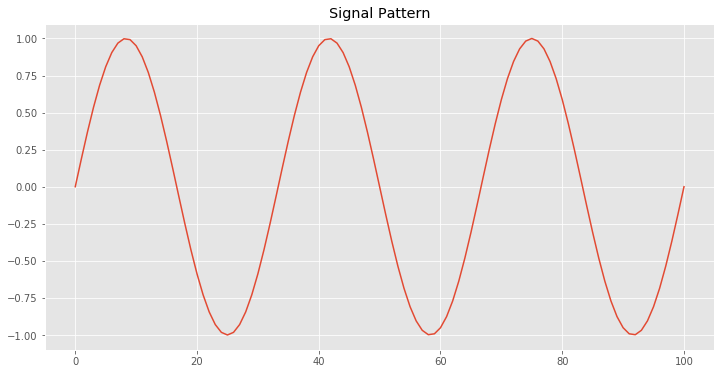

In [6]:
plt.figure(**PLTARGS)
plt.title('Signal Pattern')
plt.plot(pattern);

Since detecting outliers on clean signals is likely trivial for humans, even for signals carrying trends or seasonality, we are going to introduce noise to the data. Further we like the setup to be reproducable, hence noise should be deterministic each time we run this notebook.

In [7]:
np.random.seed(seed=456733626)

In [8]:
N_SENSORS = 100
AMPLITUDE = (10, 40)
YSHIFT = (50, 100)
SIGMA = 3
MU = 0

random_range = lambda x: np.random.rand() * (x[1]-x[0]) + x[0]

sensors = np.zeros((N_SENSORS, N_SAMPLES+1))

for i in range(N_SENSORS):
    noise = np.random.randn(N_SAMPLES+1) * SIGMA + MU
    signal = pattern * random_range(AMPLITUDE) + random_range(YSHIFT)
    sensors[i,:] = np.add(signal, noise)
    
sensor_names = np.array(['sensor%03d' % (n + 1) for n in range(N_SENSORS)])
    
df_sensors = pd.DataFrame(sensors.T, columns=sensor_names)

In [9]:
df_sensors.shape

(101, 100)

In [10]:
df_sensors.head()

,sensor001,sensor002,sensor003,sensor004,sensor005,sensor006,sensor007,sensor008,sensor009,sensor010,...,sensor091,sensor092,sensor093,sensor094,sensor095,sensor096,sensor097,sensor098,sensor099,sensor100
0,57.669753,55.402151,82.059911,101.330584,72.193168,76.323176,67.939596,55.209994,94.401344,63.896688,...,78.370841,51.074473,66.572422,82.071946,76.488259,61.076351,85.582060,73.741268,83.936137,59.517250
1,70.311771,52.085679,90.414549,104.836928,77.066970,81.631386,65.517215,55.104898,100.779719,69.845241,...,87.206179,60.980816,75.009266,89.267616,79.377751,67.464724,95.259478,74.283086,86.982747,64.620717
2,72.548859,58.951096,91.945815,109.998149,79.623673,98.080501,72.742849,56.607973,107.315154,74.671570,...,93.660543,57.301636,77.096759,89.065491,81.528715,73.127496,106.216898,77.758512,94.061979,65.970785
3,77.433816,64.305066,96.712043,120.501086,82.270410,102.604483,75.400317,56.468985,113.346710,84.698771,...,99.600155,60.173177,85.653563,88.118402,87.065765,71.770925,110.571264,82.384638,103.378881,68.286718
4,81.208526,66.462879,105.900953,126.676805,84.749135,105.110573,70.985151,61.982732,117.715207,88.588342,...,103.818871,60.849628,86.701732,90.846210,87.280598,79.966766,109.021662,92.751971,107.465006,67.001825


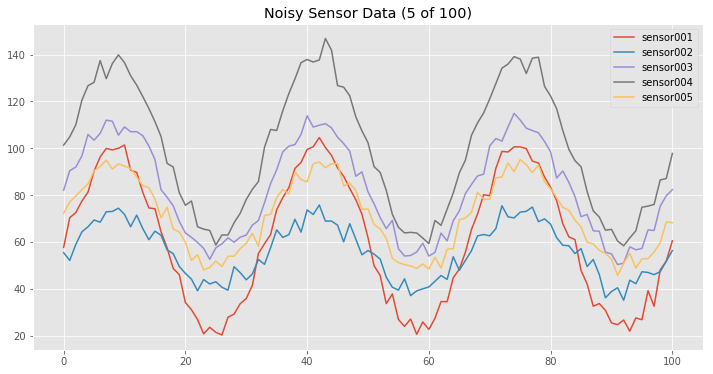

In [11]:
df_sensors.iloc[:, :5].plot(title='Noisy Sensor Data (5 of 100)', **PLTARGS);

In [12]:
ANOMALY_DURATION = 10
ANOMALY_INTENSITY = 10

anomaly_map = np.random.rand(N_SENSORS) < 0.1

anomalies = np.zeros((N_SENSORS, N_SAMPLES+1))

for i, malign in enumerate(anomaly_map):
    if malign:
        onset = np.random.randint(N_SAMPLES - ANOMALY_DURATION)
        sign = -1 if np.random.randn() < 0.5 else 1
        noise = np.random.normal(0, 1, ANOMALY_DURATION) + ANOMALY_INTENSITY
        anomalies[i, onset:onset+ANOMALY_DURATION] = sign * noise

df_anomalies = pd.DataFrame(anomalies.T, columns=sensor_names)

In [13]:
df_anomalies.shape

(101, 100)

In [14]:
samples = np.where(anomaly_map)[0][:3]
print(sensor_names[samples])

['sensor002' 'sensor003' 'sensor011']


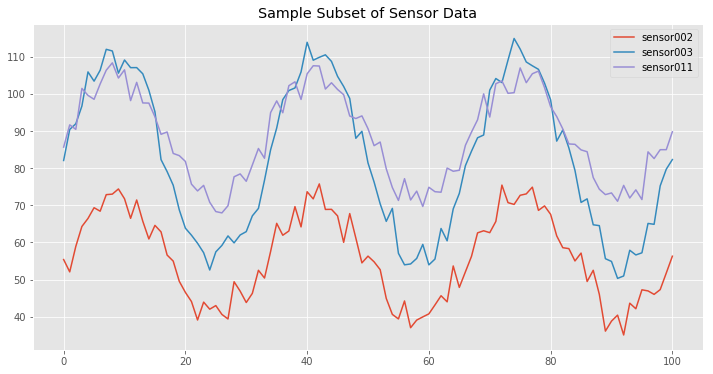

In [15]:
df_sensors.iloc[:, samples].plot(title='Sample Subset of Sensor Data', **PLTARGS);

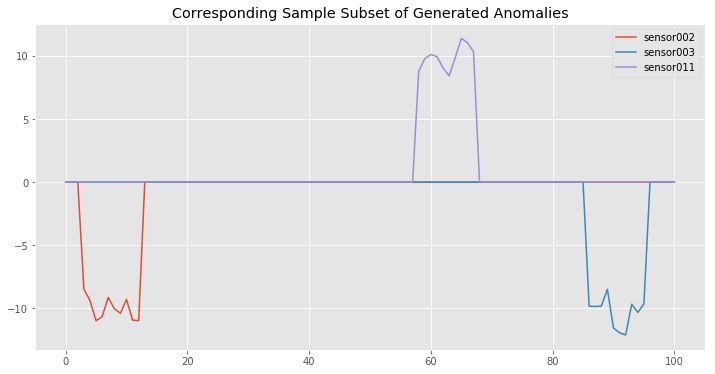

In [16]:
df_anomalies.iloc[:, samples].plot(title='Corresponding Sample Subset of Generated Anomalies', **PLTARGS);

In [17]:
df_sensors_with_anomalies = df_sensors + df_anomalies

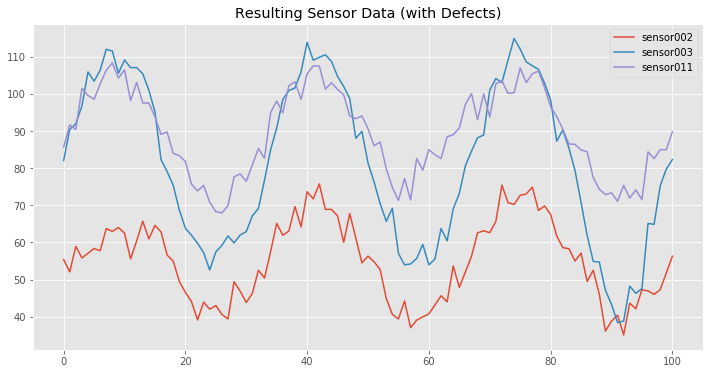

In [18]:
df_sensors_with_anomalies.iloc[:, samples].plot(title='Resulting Sensor Data (with Defects)', **PLTARGS);

In [19]:
model = RobustPCA(method='sparse', max_iter=1000)

In [20]:
%%time

sparse_matrix = model.transform(df_sensors_with_anomalies.values.T)

CPU times: user 3.94 s, sys: 505 ms, total: 4.45 s
Wall time: 3.96 s


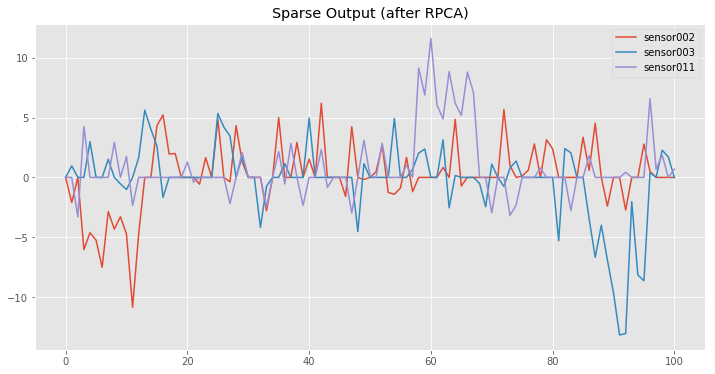

In [21]:
df_anomalies_estimated = pd.DataFrame(sparse_matrix.T, columns=sensor_names)
df_anomalies_estimated.iloc[:, samples].plot(title='Sparse Output (after RPCA)', **PLTARGS);

In [22]:
mean = np.mean(df_anomalies_estimated.values)
std = np.std(df_anomalies_estimated.values)

In [23]:
df_anomalies_zscore = (df_anomalies_estimated - mean) / std

In [24]:
THRESHOLD = 3

df_outliers = df_anomalies_zscore[(df_anomalies_zscore >= THRESHOLD) | (df_anomalies_zscore <= -THRESHOLD)]

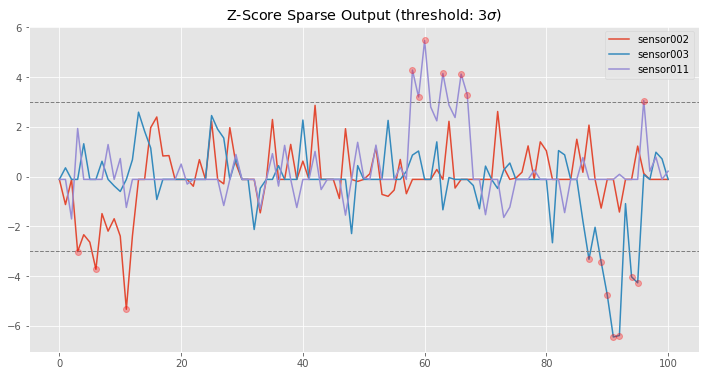

In [25]:
ax = df_anomalies_zscore.iloc[:, samples].plot(title='Z-Score Sparse Output (threshold: $%d\sigma$)' % THRESHOLD, 
                                               **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_outliers.iloc[:, samples].plot(ax=ax, legend=False, linestyle='none', color='r', marker="o", alpha=.3);

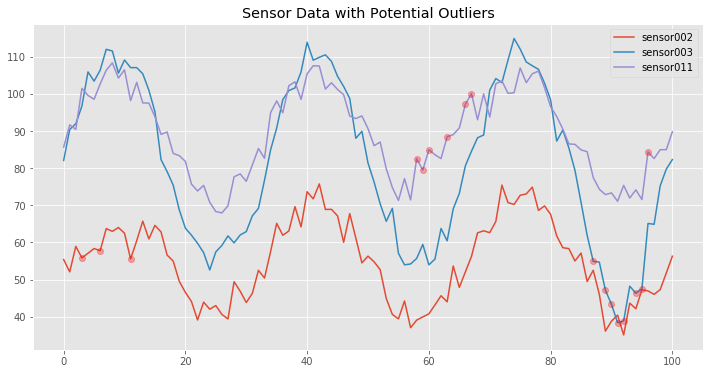

In [26]:
ax = df_sensors_with_anomalies.iloc[:, samples].plot(title='Sensor Data with Potential Outliers', **PLTARGS)
df_sensors_with_anomalies[df_outliers.iloc[:, samples].isnull() == False].plot(ax=ax, legend=False, linestyle='none',
                                                                               color='r', marker="o", alpha=.3);

## Real World Data
### Ad Exchange Data (Cost Per Impression)

In [27]:
!head -n 5 data/exchange-2_cpm_results.csv | tr ',' '\t'

In [28]:
df_cpm = pd.read_csv('data/exchange-2_cpm_results.csv', index_col='date', names=['date', 'cpm'],
                     sep=',', parse_dates=True, header=0)

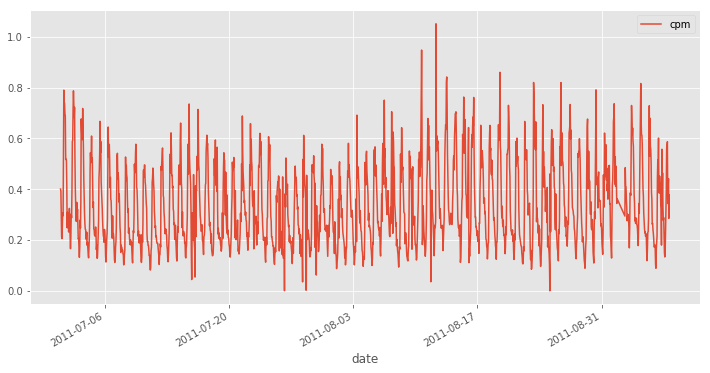

In [29]:
df_cpm.plot(**PLTARGS);

In [30]:
!sed -n '1502,1517p' data/exchange-2_cpc_results.csv | tr ',' '\t'

In [31]:
df_cpm = df_cpm.resample('1h').mean()

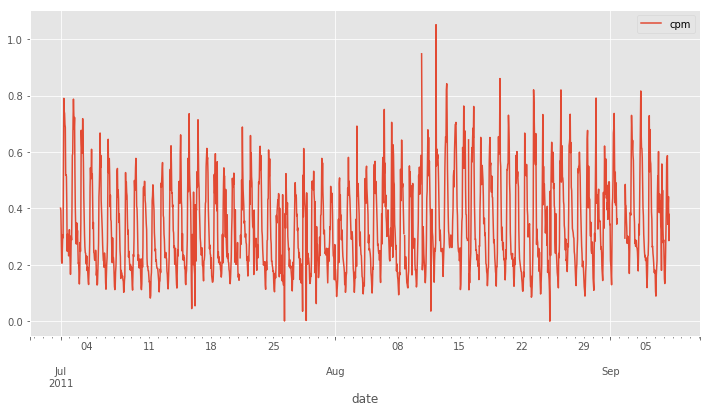

In [32]:
df_cpm.plot(**PLTARGS);

In [33]:
df_cpm = df_cpm.interpolate(method='linear')

In [34]:
df_cpm['week'] = df_cpm.index.weekofyear
df_cpm['day'] = df_cpm.index.dayofweek
df_cpm['hour'] = df_cpm.index.hour

df_cpm_by_week = pd.pivot_table(df_cpm, index=['day', 'hour'], columns=['week'], values='cpm',
                           aggfunc=np.mean)

In [35]:
df_cpm_by_week.shape

(168, 11)

In [36]:
df_cpm_by_week.isnull().sum().sum()

200

In [37]:
df_cpm_by_week.isnull().sum()

week
26     96
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36    104
dtype: int64

In [38]:
df_cpm_by_week = df_cpm_by_week.dropna(axis=1, how='any')

In [39]:
df_cpm_by_week.shape

(168, 9)

In [40]:
df_cpm_by_week.isnull().sum().sum()

0

In [41]:
df_cpm_by_week.head()

week            27        28        29        30        31        32  \
day hour                                                               
0   0     0.179942  0.139389  0.225183  0.178073  0.183855  0.158421   
    1     0.192673  0.140955  0.161582  0.135347  0.146499  0.147071   
    2     0.166335  0.092254  0.150193  0.114143  0.136459  0.121540   
    3     0.142272  0.082216  0.138530  0.104570  0.087786  0.093912   
    4     0.130355  0.090850  0.139423  0.144247  0.113553  0.125770   

week            33        34        35  
day hour                                
0   0     0.219272  0.151385  0.148677  
    1     0.259993  0.136277  0.122675  
    2     0.112466  0.110605  0.109182  
    3     0.129890  0.106407  0.089285  
    4     0.184369  0.123629  0.124575

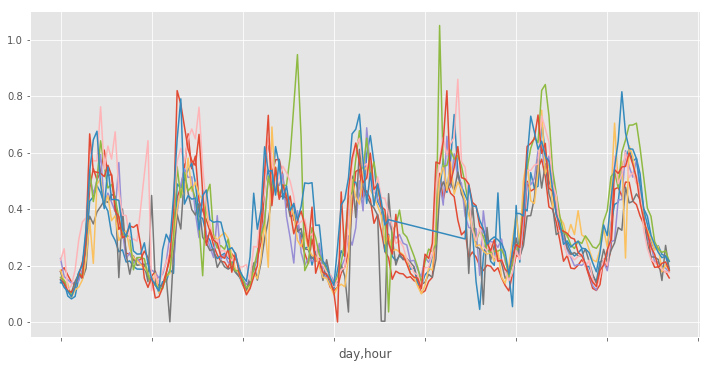

In [42]:
df_cpm_by_week.plot(legend=False, **PLTARGS);

In [43]:
%%time

cpm_sparse = model.transform(df_cpm_by_week.values.T)

CPU times: user 263 ms, sys: 3.94 ms, total: 267 ms
Wall time: 273 ms


In [44]:
cpm_mean = np.mean(cpm_sparse)
cpm_std = np.std(cpm_sparse)

cpm_sparse_zscore = (cpm_sparse - cpm_mean) / cpm_std

df_cpm_anomalies = pd.DataFrame(cpm_sparse_zscore.T, columns=df_cpm_by_week.columns, index=df_cpm_by_week.index)

In [45]:
THRESHOLD = 2

df_cpm_outliers = df_cpm_anomalies[(df_cpm_anomalies >= THRESHOLD) | (df_cpm_anomalies <= -THRESHOLD)]

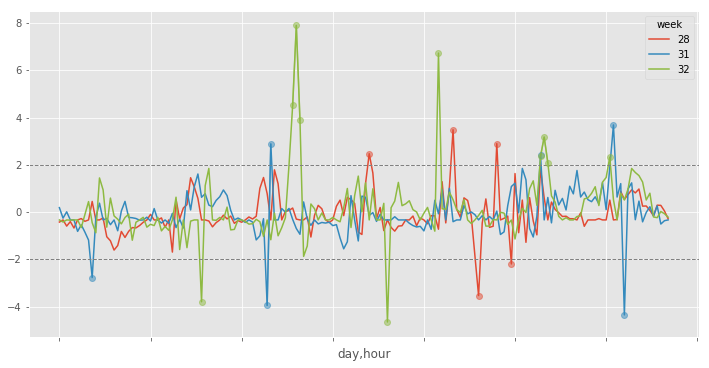

In [46]:
weeks = [28, 31, 32]
colors = ['C0', 'C1', 'C5']

ax = df_cpm_anomalies[weeks].plot(color=colors, **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_cpm_outliers[weeks].plot(ax=ax, marker='o', color=colors, alpha=.5, linestyle=None, label='outlier', legend=False);

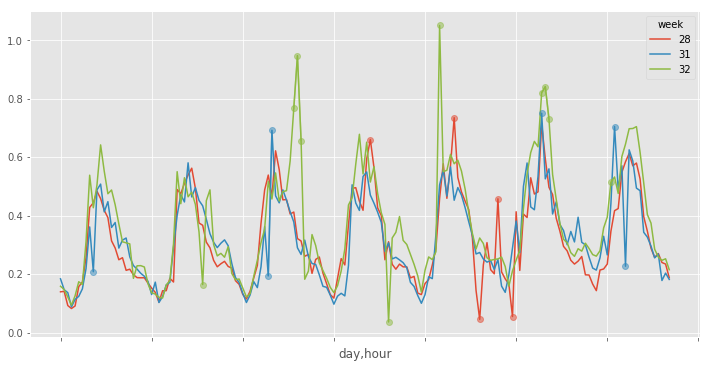

In [47]:
ax = df_cpm_by_week[weeks].plot(color=colors, **PLTARGS)
df_cpm_by_week[df_cpm_outliers.isnull() == False][weeks].plot(ax=ax, marker='o', color=colors,
                                                         alpha=.5, linestyle=None, legend=False);

## References

[The Augmented Lagrange Multiplier Method for Exact Recovery of Corrupted Low-Rank Matrices][LIN2009] (Zhouchen Lin, Minming Chen, Yi Ma)

[LIN2009]: https://arxiv.org/abs/1009.5055